# Sentiment Classification With a Transformer

In this notebook, we revert to the classification task of the International Movie Database website www.imdb.com with reviews labeled with a binary rating whether they are positive (label 1) or negative (label 0).

## Set-up
First of all, we need to load the libraries that we will need for this task. We will use keras and tensorflow for this code example, so we load the relevant parts of this framework:

In [1]:
!pip install tensorflow_datasets

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.2 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21501 sha256=dcb997178b09efe8ab1bca92014d1772312dd7e8fc990c79874375bfe6d34719
  Stored in directory: /home/jovyan/.cache/pip/wheels/54/4e/28/3ed0e1c8a752867445bab994d2340724928aa3ab059c57c8db
Successfully built promise


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

2025-09-19 09:39:40.688682: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-19 09:39:40.747112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-19 09:39:40.747142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-19 09:39:40.748125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-19 09:39:40.754258: I tensorflow/core/platform/cpu_feature_guar

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Conv1D, MaxPooling1D, Flatten, LSTM, Bidirectional
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant

In [4]:
tf.config.run_functions_eagerly(True)
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [5]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [6]:
# some more general libraries for evaluation purposes:
import matplotlib.pyplot as plt
import datetime

In [7]:
import pickle

Define parameters:

In [8]:
VOCAB_SIZE = 5000  # Only consider the top 20k words
MAX_LEN = 200  # Only consider the first 200 words of each movie review

EMBED_DIM = 100  # Embedding size for each token
NUM_HEADS = 3  # Number of attention heads
FF_DIM = 32  # Hidden layer size in feed forward network inside transformer

NUM_EPOCHS = 5

batch_size = 32

## Data Loading

We now use a different, more direct way to get the imdb data. Using the tensorflow keras datasets subpackage, we can directly get a vectorized representation of the imdb movie reviews

In [9]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=VOCAB_SIZE)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = tf.keras.utils.pad_sequences(x_train, maxlen=MAX_LEN)
x_val = tf.keras.utils.pad_sequences(x_val, maxlen=MAX_LEN)

17464789/17464789 [==============================] - 1s 0us/step
25000 Training sequences
25000 Validation sequences


## Transformer


In [10]:
import os

In [11]:
%run Transformers.ipynb

# Review Rater with Transformers
Using the building blocks defined in the previous notebook, we can simply combine the necessary blocks. Here, we use the Encoder part of the transformer, and then just add a few layers as classification head.

In [12]:
# initialize random number generators to ensure reproducibility:
tf.random.set_seed(123)
np.random.seed(123)

In [13]:
class ReviewRater(tf.keras.Model):
    def __init__(self, *, num_layers, embed_dim, num_heads, ff_dim,
                 input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        # Encoder Block
        self.encoder = Encoder(num_layers=num_layers, embed_dim=embed_dim,
                               num_heads=num_heads, ff_dim=ff_dim,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        # custom classification head
        self.globAvgPool = tf.keras.layers.GlobalAveragePooling1D()

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.dense20 = tf.keras.layers.Dense(20, activation="relu")
        self.dense2  = tf.keras.layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.globAvgPool(x)
        x = self.dropout(x)
        x = self.dense20(x)
        outputs = self.dense2(x)

        return outputs

In [14]:
model_5kW_trans_RR = ReviewRater(num_layers=1, embed_dim=EMBED_DIM, num_heads=NUM_HEADS,
                                 ff_dim=FF_DIM, input_vocab_size=VOCAB_SIZE,
                                 target_vocab_size=VOCAB_SIZE)

In [15]:
model_5kW_trans_RR.compile(loss = BinaryCrossentropy(from_logits=False),
                           optimizer = 'adam', metrics = ['accuracy'])

As with the previous models, we only train the models from scratch if needed, and load the pre-trained model weights and results from files otherwise:

In [16]:
train_from_scatch = True

model_name = 'transformer,  100 dim'
model_weight_file = model_name + '_weights'
model_result_file = model_name + '_Results.pkl'

if train_from_scatch: 
    myRRHistory = model_5kW_trans_RR.fit(
        x_train, y_train,
        validation_data = (x_val, y_val),
        epochs = NUM_EPOCHS, verbose = 1,
        callbacks = [ EarlyStopping(monitor='val_accuracy', patience=5,
                                    verbose=False, restore_best_weights=True)])

    myRRHistory_dict = myRRHistory.history
    resDict_5kW_trans_RR = {}
    resDict_5kW_trans_RR['train_loss'] = myRRHistory_dict['loss']
    resDict_5kW_trans_RR['val_loss'] = myRRHistory_dict['val_loss']
    resDict_5kW_trans_RR['train_accuracy'] = myRRHistory_dict['accuracy']
    resDict_5kW_trans_RR['val_accuracy'] = myRRHistory_dict['val_accuracy']
    resDict_5kW_trans_RR['epochs'] = range(1, len(resDict_5kW_trans_RR['train_accuracy']) + 1)
    resDict_5kW_trans_RR['model_name'] = model_name
    
    # save weights and results
    model_5kW_trans_RR.save_weights(model_weight_file)
    with open(model_result_file, 'wb') as f:
        pickle.dump(resDict_5kW_trans_RR, f)
else:
    model_5kW_trans_RR.load_weights(model_weight_file)
    with open(model_result_file, 'rb') as input_file:
        resDict_5kW_trans_RR = pickle.load(input_file)

/home/jovyan/tensorflow-venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5
782/782 [==============================] - 210s 268ms/step - loss: 0.3594 - accuracy: 0.8356 - val_loss: 0.2937 - val_accuracy: 0.8746
Epoch 2/5
782/782 [==============================] - 186s 238ms/step - loss: 0.2469 - accuracy: 0.8999 - val_loss: 0.3011 - val_accuracy: 0.8739
Epoch 3/5
782/782 [==============================] - 185s 237ms/step - loss: 0.2132 - accuracy: 0.9165 - val_loss: 0.3223 - val_accuracy: 0.8727
Epoch 4/5
782/782 [==============================] - 181s 231ms/step - loss: 0.1841 - accuracy: 0.9275 - val_loss: 0.3647 - val_accuracy: 0.8611
Epoch 5/5
782/782 [==============================] - 179s 229ms/step - loss: 0.1561 - accuracy: 0.9400 - val_loss: 0.3742 - val_accuracy: 0.8583


In [17]:
model_5kW_trans_RR.summary()

Model: "review_rater"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  627932    
                                                                 
 global_average_pooling1d (  multiple                  0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  2020      
                                                                 
 dense_3 (Dense)             multiple                  21        
                                                                 
Total params: 629973 (2.40 MB)
Trainable params: 629973 (2.40 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

Now we visualize the development of the accuracy and the loss over the training epochs:

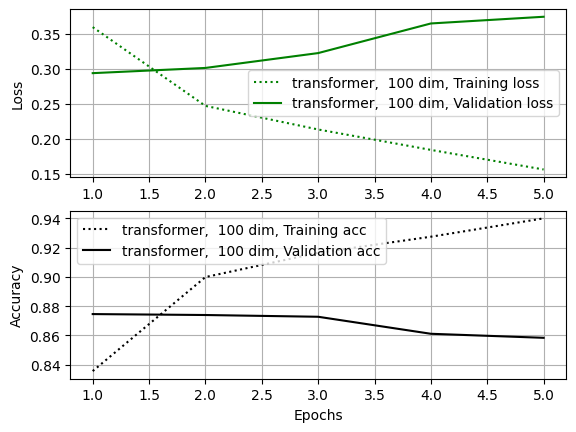

In [18]:
plt.subplot(2, 1, 1)
plt.plot(resDict_5kW_trans_RR['epochs'], resDict_5kW_trans_RR['train_loss'],
         'g:', label = resDict_5kW_trans_RR['model_name'] +', Training loss')
plt.plot(resDict_5kW_trans_RR['epochs'], resDict_5kW_trans_RR['val_loss'],
         'g',  label = resDict_5kW_trans_RR['model_name'] +', Validation loss')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(resDict_5kW_trans_RR['epochs'], resDict_5kW_trans_RR['train_accuracy'],
         'k:', label = resDict_5kW_trans_RR['model_name'] +', Training acc')
plt.plot(resDict_5kW_trans_RR['epochs'], resDict_5kW_trans_RR['val_accuracy'],
         'k',  label = resDict_5kW_trans_RR['model_name'] +', Validation acc')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.xlabel('Epochs')
plt.show()

Using the results from the previous notebook on LSTM, we can compare the accuracy of e.g. the 1-layer LSTM network with our transformer network. Note that this will only work if you have run the `Sentiment_Analysis_LSTM_pretrainedEmbeddings` notebook before, and have the files from this run still available. If you have so, please uncomment the respective lines in the next two cells.

In [ ]:
model_name = 'Pretrained_Adapted_Embeddings_100_dim'
model_weight_file = model_name + '_weights'
model_result_file = model_name + '_Results.pkl'

# with open(model_result_file, 'rb') as input_file:
#     resDict_ae100_1LSTM = pickle.load(input_file)

In [ ]:
plt.plot(resDict_5kW_trans_RR['epochs'], resDict_5kW_trans_RR['train_accuracy'],
         'k:', label = resDict_5kW_trans_RR['model_name'] +', Training acc')
plt.plot(resDict_5kW_trans_RR['epochs'], resDict_5kW_trans_RR['val_accuracy'],
         'k',  label = resDict_5kW_trans_RR['model_name'] +', Validation acc')

# plt.plot(resDict_ae100_1LSTM['epochs'], resDict_ae100_1LSTM['train_accuracy'],
#          'g:', label = resDict_ae100_1LSTM['model_name'] +', Training acc')
# plt.plot(resDict_ae100_1LSTM['epochs'], resDict_ae100_1LSTM['val_accuracy'],
#          'g',  label = resDict_ae100_1LSTM['model_name'] +', Validation acc')

plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.xlabel('Epochs')
plt.show()

We see that the transformer-based solution achieves a good accuracy already after a first training epoch, but then suffers from overfitting. The LSTM-based classifier with adapted, pretrained embeddings takes longer to achieve good performance, but then actually outperforms the transformer-based solution.